## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time


from implementation.dropout import Dropout
from utils.tensor_loader import FastTensorDataLoader
from utils.plots import plot_dropout_histories

np.random.seed(42)
torch.manual_seed(42)

## Simple Distribution Validation
Test to see if both standard and inverted dropout show expected results

In [2]:
p = 0.5
input_tensor = torch.ones(500, 500) 

# inverted
drop_inv = Dropout(p=p, mode="inverted")
drop_inv.train()
out_inv = drop_inv(input_tensor)
# 50% is dropped. The mean would be 0.5, but scaling should make it close to 1
print(f"Inverted (Train) Mean: {out_inv.mean():.4f} (Expected ~1.0)")
    
drop_inv.eval()
out_inv_eval = drop_inv(input_tensor)
print(f"Inverted (Eval)  Mean: {out_inv_eval.mean():.4f} (Expected 1.0)\n")

# standard
drop_std = Dropout(p=p, mode="standard")
drop_std.train()
out_std = drop_std(input_tensor)
print(f"Standard (Train) Mean: {out_std.mean():.4f} (Expected ~0.5)")
    
drop_std.eval()
out_std_eval = drop_std(input_tensor)
# Tensors are not dropped. The mean would be 1.0, but scaling should make it close to 0.5
print(f"Standard (Eval)  Mean: {out_std_eval.mean():.4f} (Expected 0.5)")

Inverted (Train) Mean: 1.0004 (Expected ~1.0)
Inverted (Eval)  Mean: 1.0000 (Expected 1.0)

Standard (Train) Mean: 0.5001 (Expected ~0.5)
Standard (Eval)  Mean: 0.5000 (Expected 0.5)


## Loading Fashion-MNIST

In [3]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [4]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

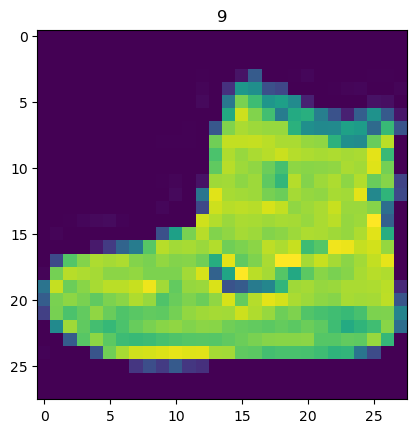

In [5]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

## Validate Dropout Using Different Models

In [6]:
# create fast dataloaders (avoid using if not enough vram)
train_loader = FastTensorDataLoader(train, shuffle=True)
test_loader = FastTensorDataLoader(test, shuffle=False)

In [ ]:
from nn_models.simple import SimpleDropoutNetwork
from nn_models.lenet import DropoutLeNet
from nn_models.vgg import DropoutVGG
from utils.validate import train_and_validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dropout_models = [
    SimpleDropoutNetwork,
    DropoutLeNet,
    DropoutVGG
]

dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted").to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 23.26it/s]


Finished in 2.58s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.65it/s]


Finished in 2.77s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.07it/s]


Finished in 2.72s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.90it/s]


Finished in 2.74s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.85it/s]


Finished in 2.75s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  6.86it/s]


Finished in 8.75s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  6.75it/s]


Finished in 8.90s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  6.74it/s]


Finished in 8.90s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  6.76it/s]


Finished in 8.88s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  6.71it/s]


Finished in 8.95s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:16<00:00,  4.28s/it]


Finished in 256.89s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:19<00:00,  4.33s/it]


Finished in 259.80s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:20<00:00,  4.34s/it]


Finished in 260.59s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:19<00:00,  4.33s/it]


Finished in 259.62s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:17<00:00,  4.30s/it]

Finished in 257.77s


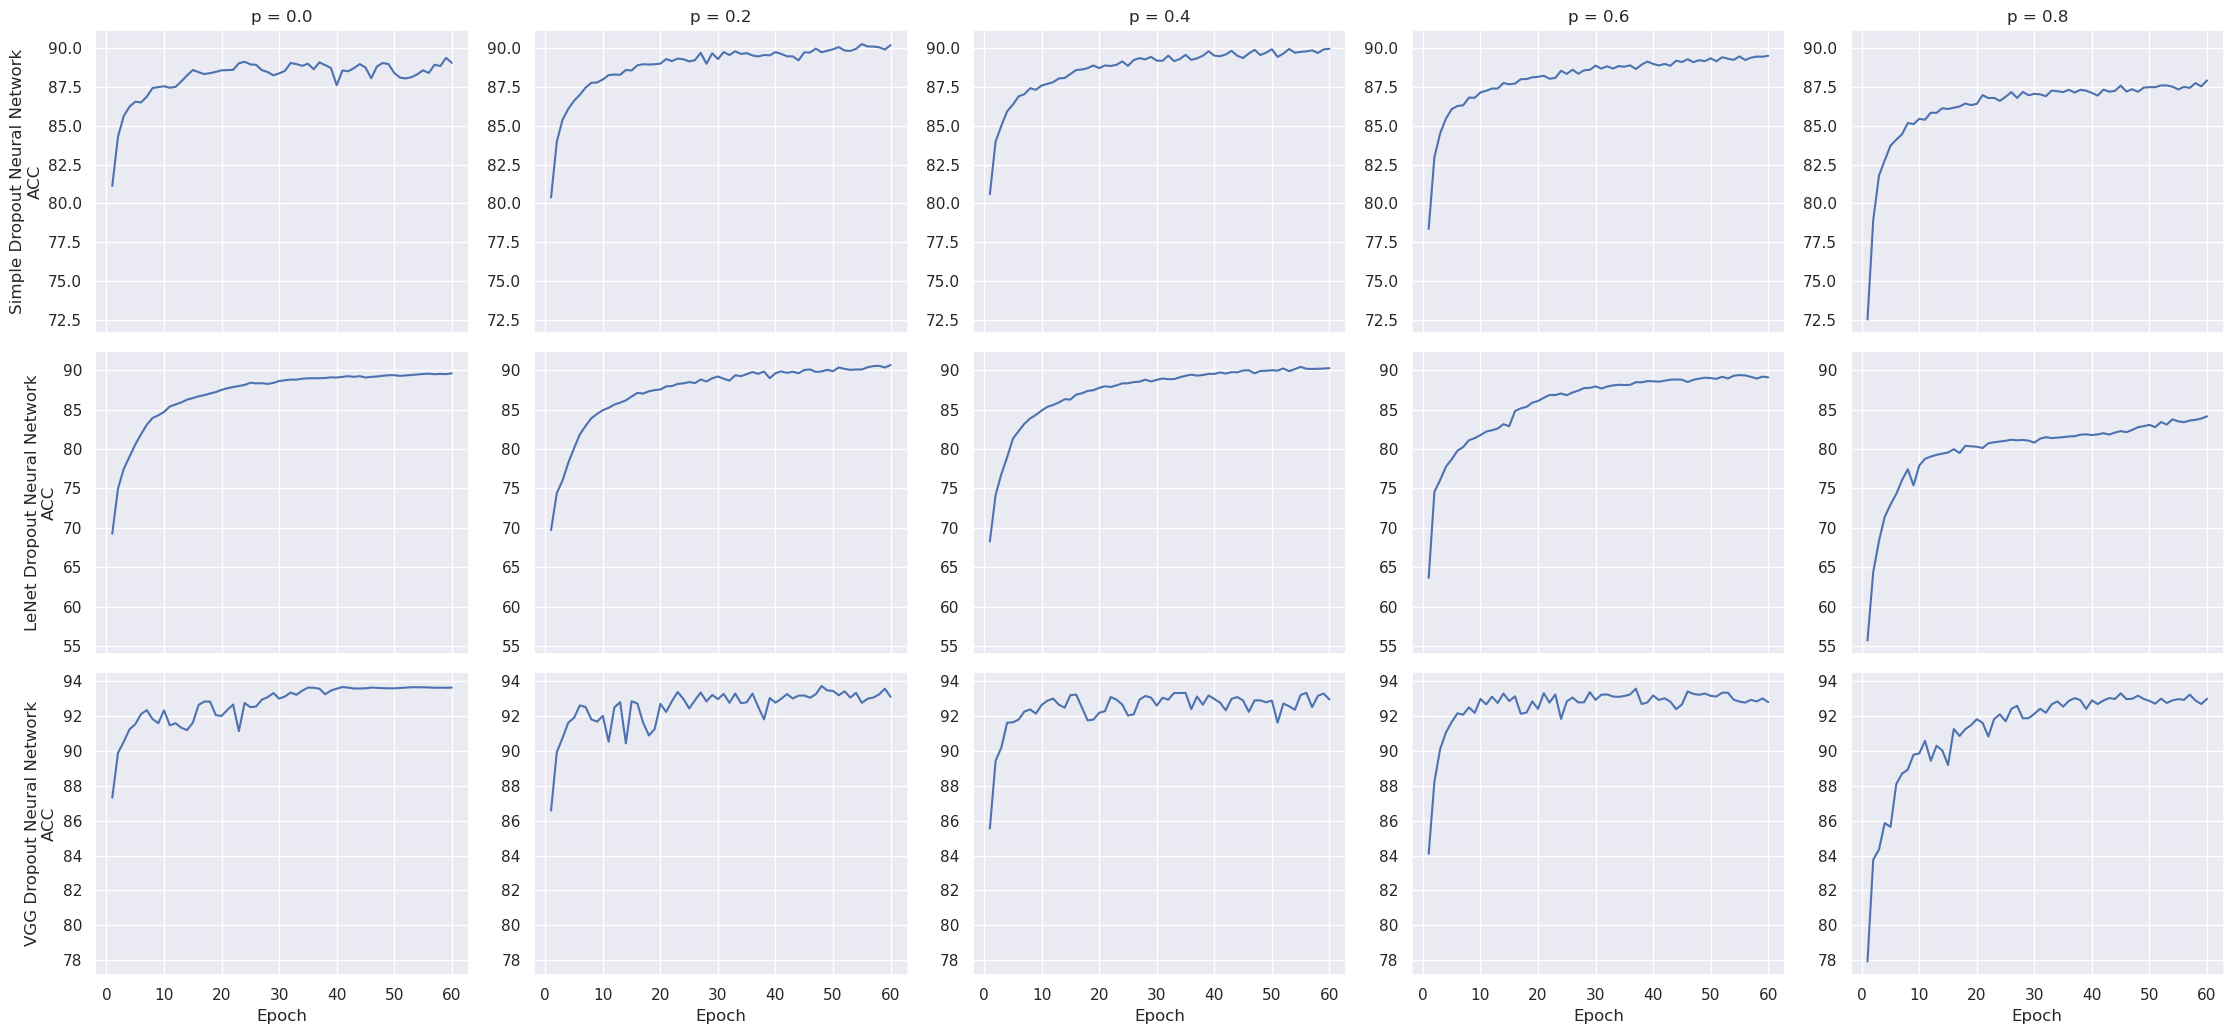

In [8]:
plot_dropout_histories(results, metric="acc")

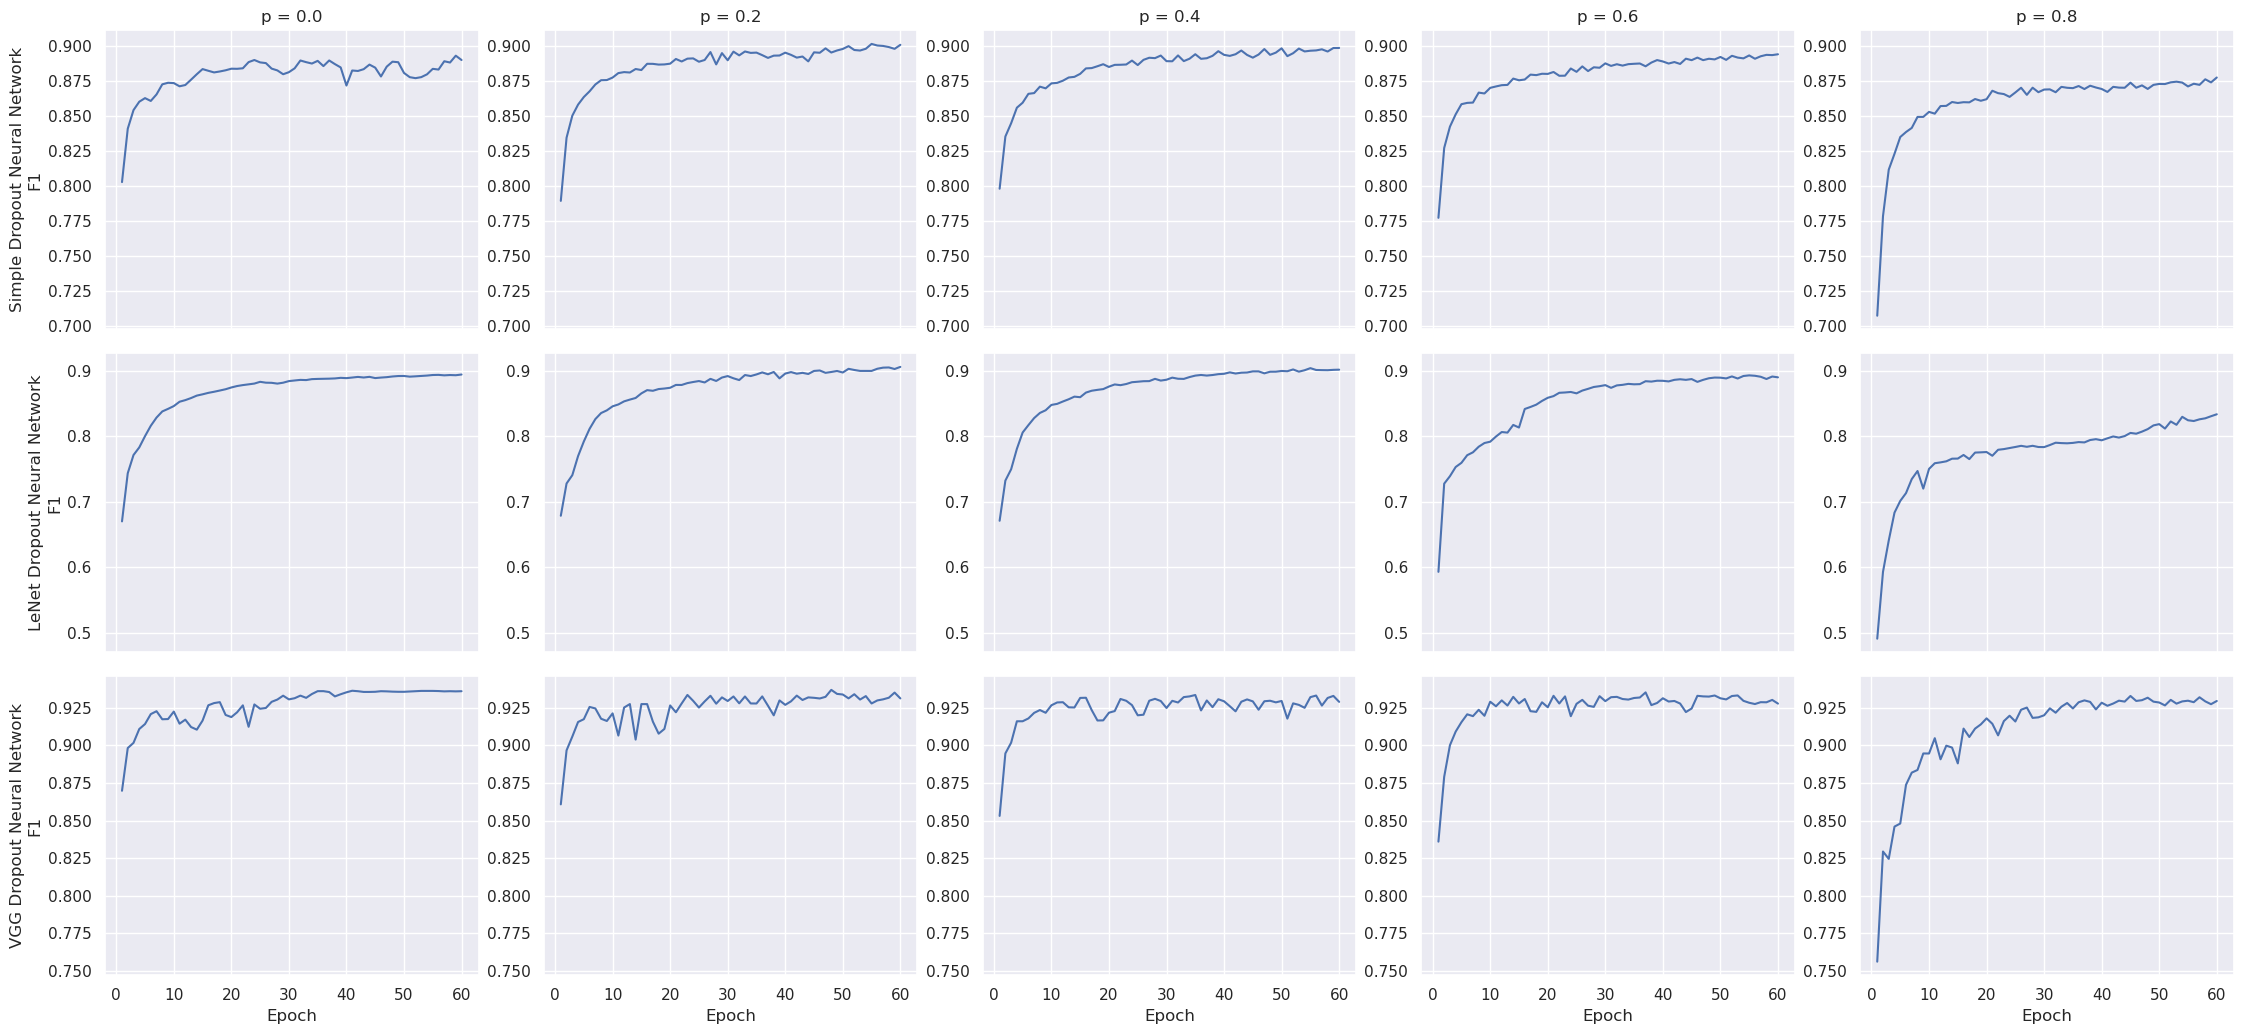

In [9]:
plot_dropout_histories(results, metric="f1")

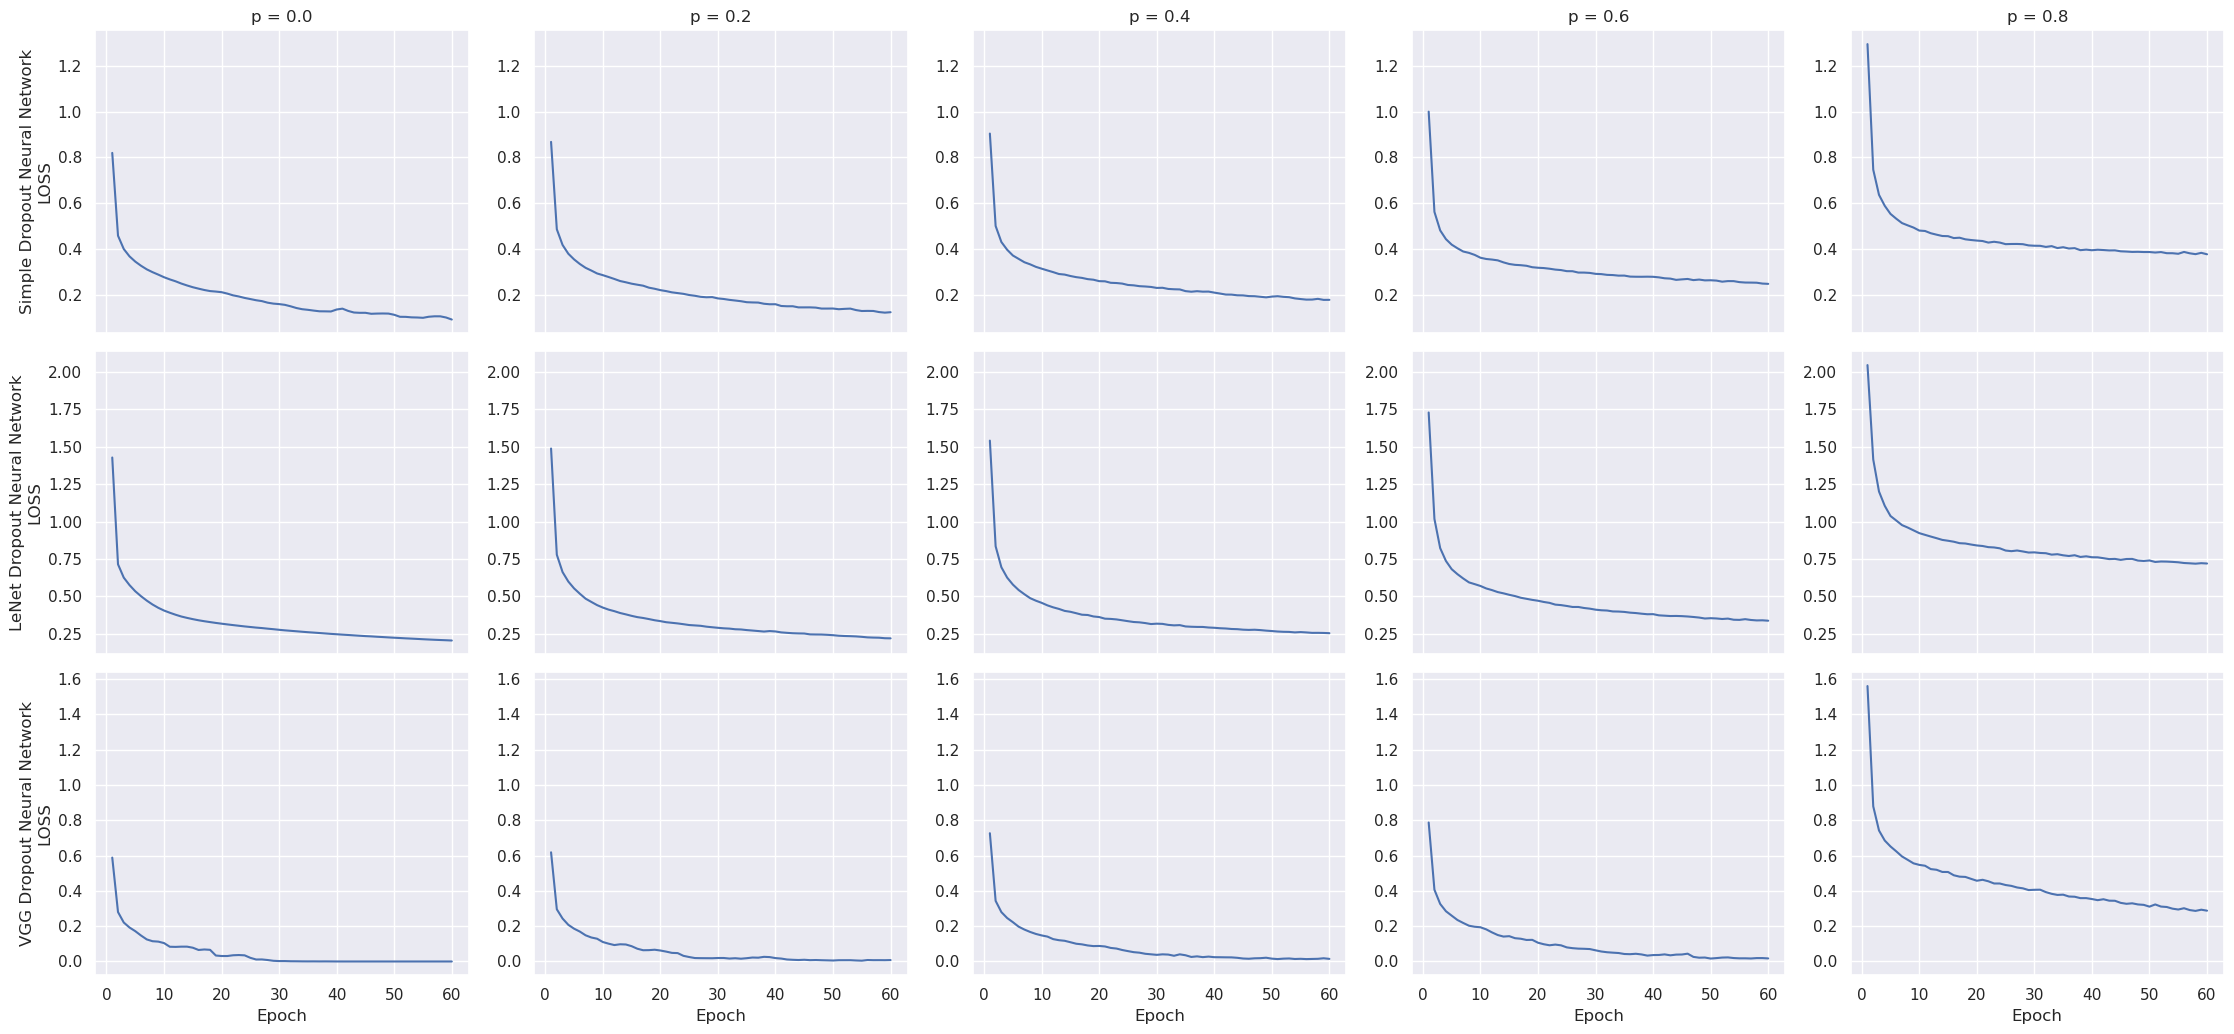

In [10]:
plot_dropout_histories(results, metric="loss")

## Training with Noise

In [61]:
len(train)

60000

In [62]:
# create noise
noise_level = 0.1
num_corrupted = int(len(train) * noise_level)

corrupt_indices = torch.randperm(len(train))[:num_corrupted]
train_loader.targets[corrupt_indices] = torch.randint(
    0, 10, (num_corrupted,), device=device
)

In [ ]:
from nn_models.simple import SimpleDropoutNetwork
from nn_models.lenet import DropoutLeNet
from nn_models.vgg import DropoutVGG
from utils.validate import train_and_validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

dropout_models = [
    SimpleDropoutNetwork,
    DropoutLeNet,
    DropoutVGG,
]

In [64]:
results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted").to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=100, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 23.98it/s]


Finished in 4.17s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 21.06it/s]


Finished in 4.75s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Finished in 4.51s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


Finished in 4.47s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 21.70it/s]


Finished in 4.61s

Testing Dropout p=0.0


Training model 'Wide Dropout Neural Network': 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Finished in 48.13s

Testing Dropout p=0.2


Training model 'Wide Dropout Neural Network': 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Finished in 51.60s

Testing Dropout p=0.4


Training model 'Wide Dropout Neural Network': 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Finished in 55.98s

Testing Dropout p=0.6


Training model 'Wide Dropout Neural Network': 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Finished in 52.69s

Testing Dropout p=0.8


Training model 'Wide Dropout Neural Network': 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Finished in 52.60s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Finished in 14.48s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Finished in 15.67s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Finished in 14.61s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Finished in 14.85s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]

Finished in 14.62s


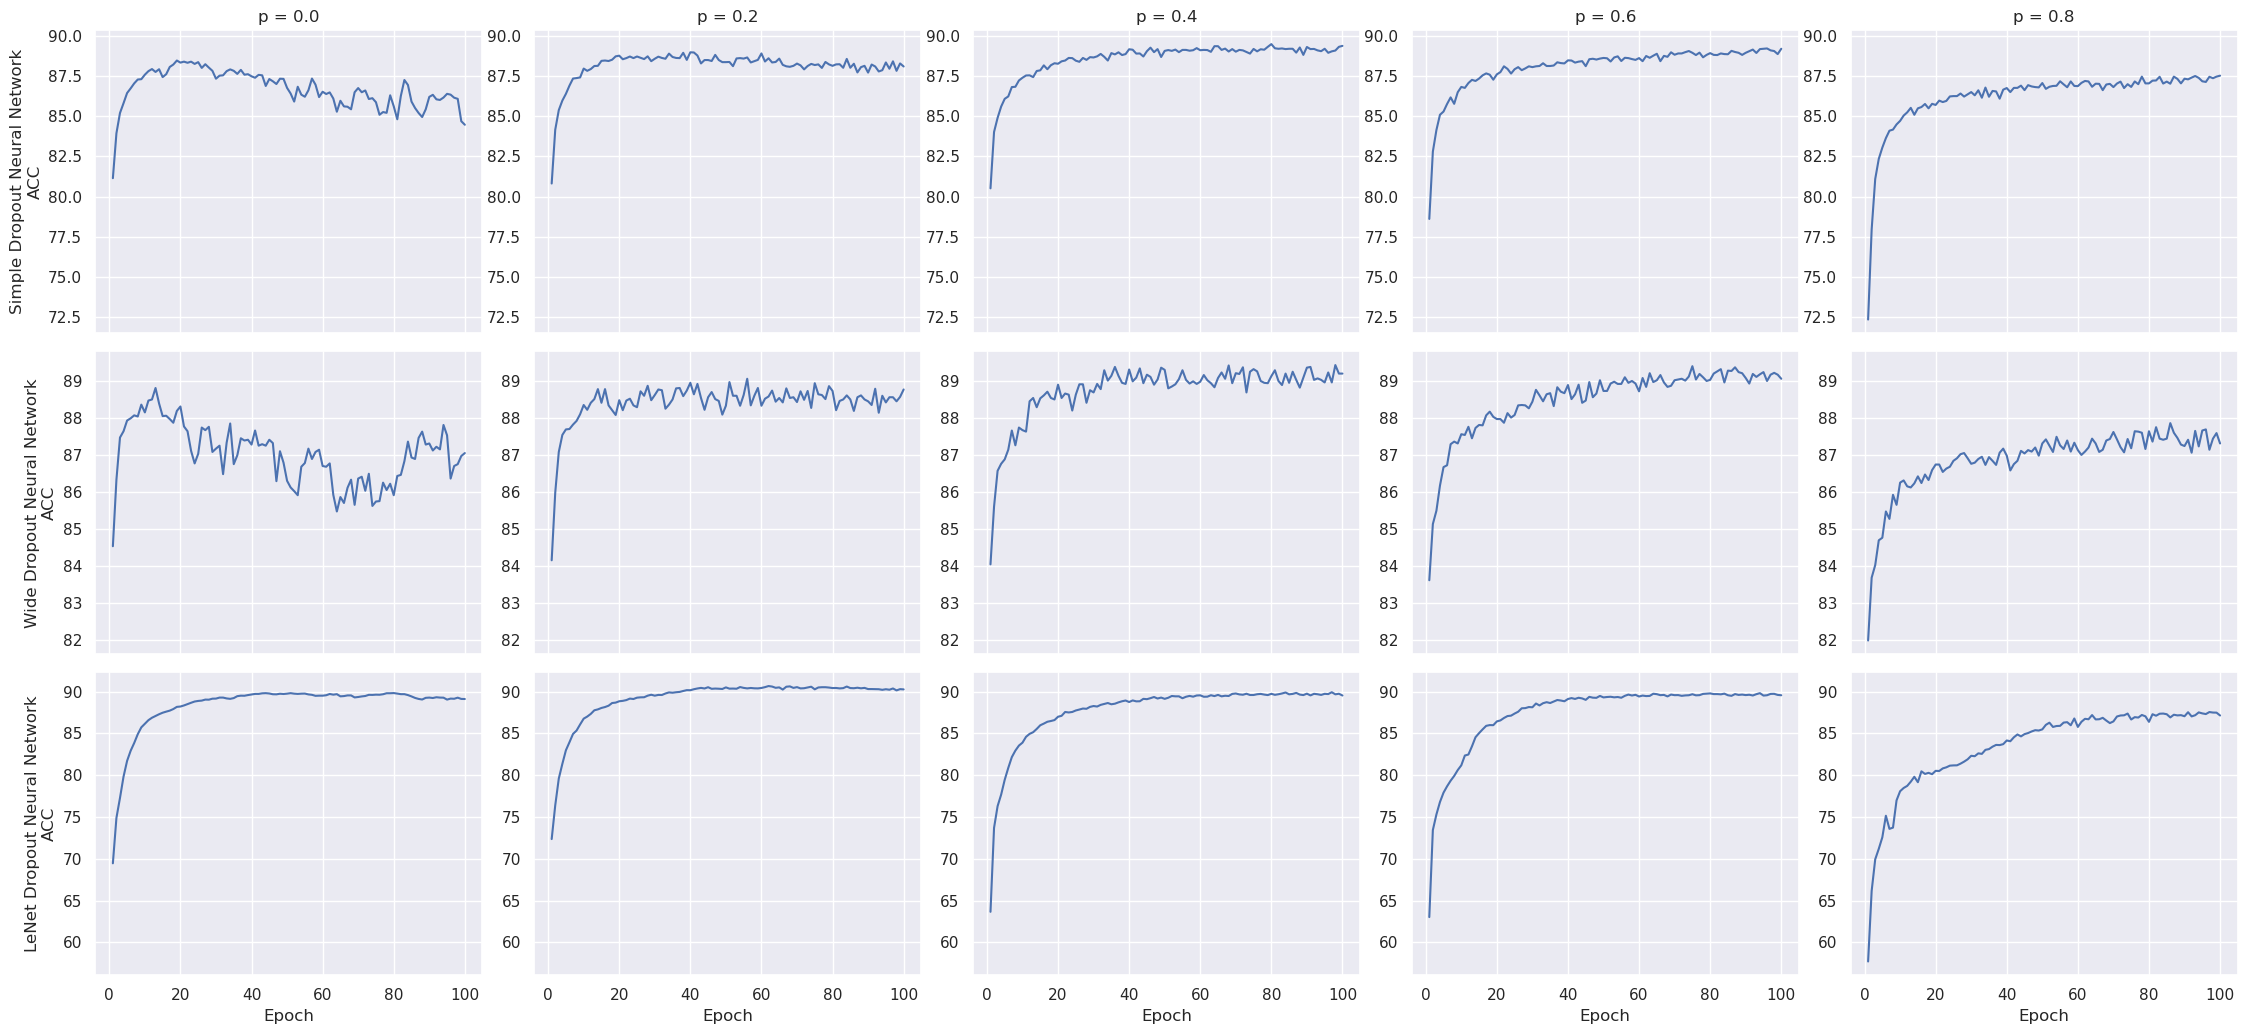

In [68]:
plot_dropout_histories(results, metric="acc")

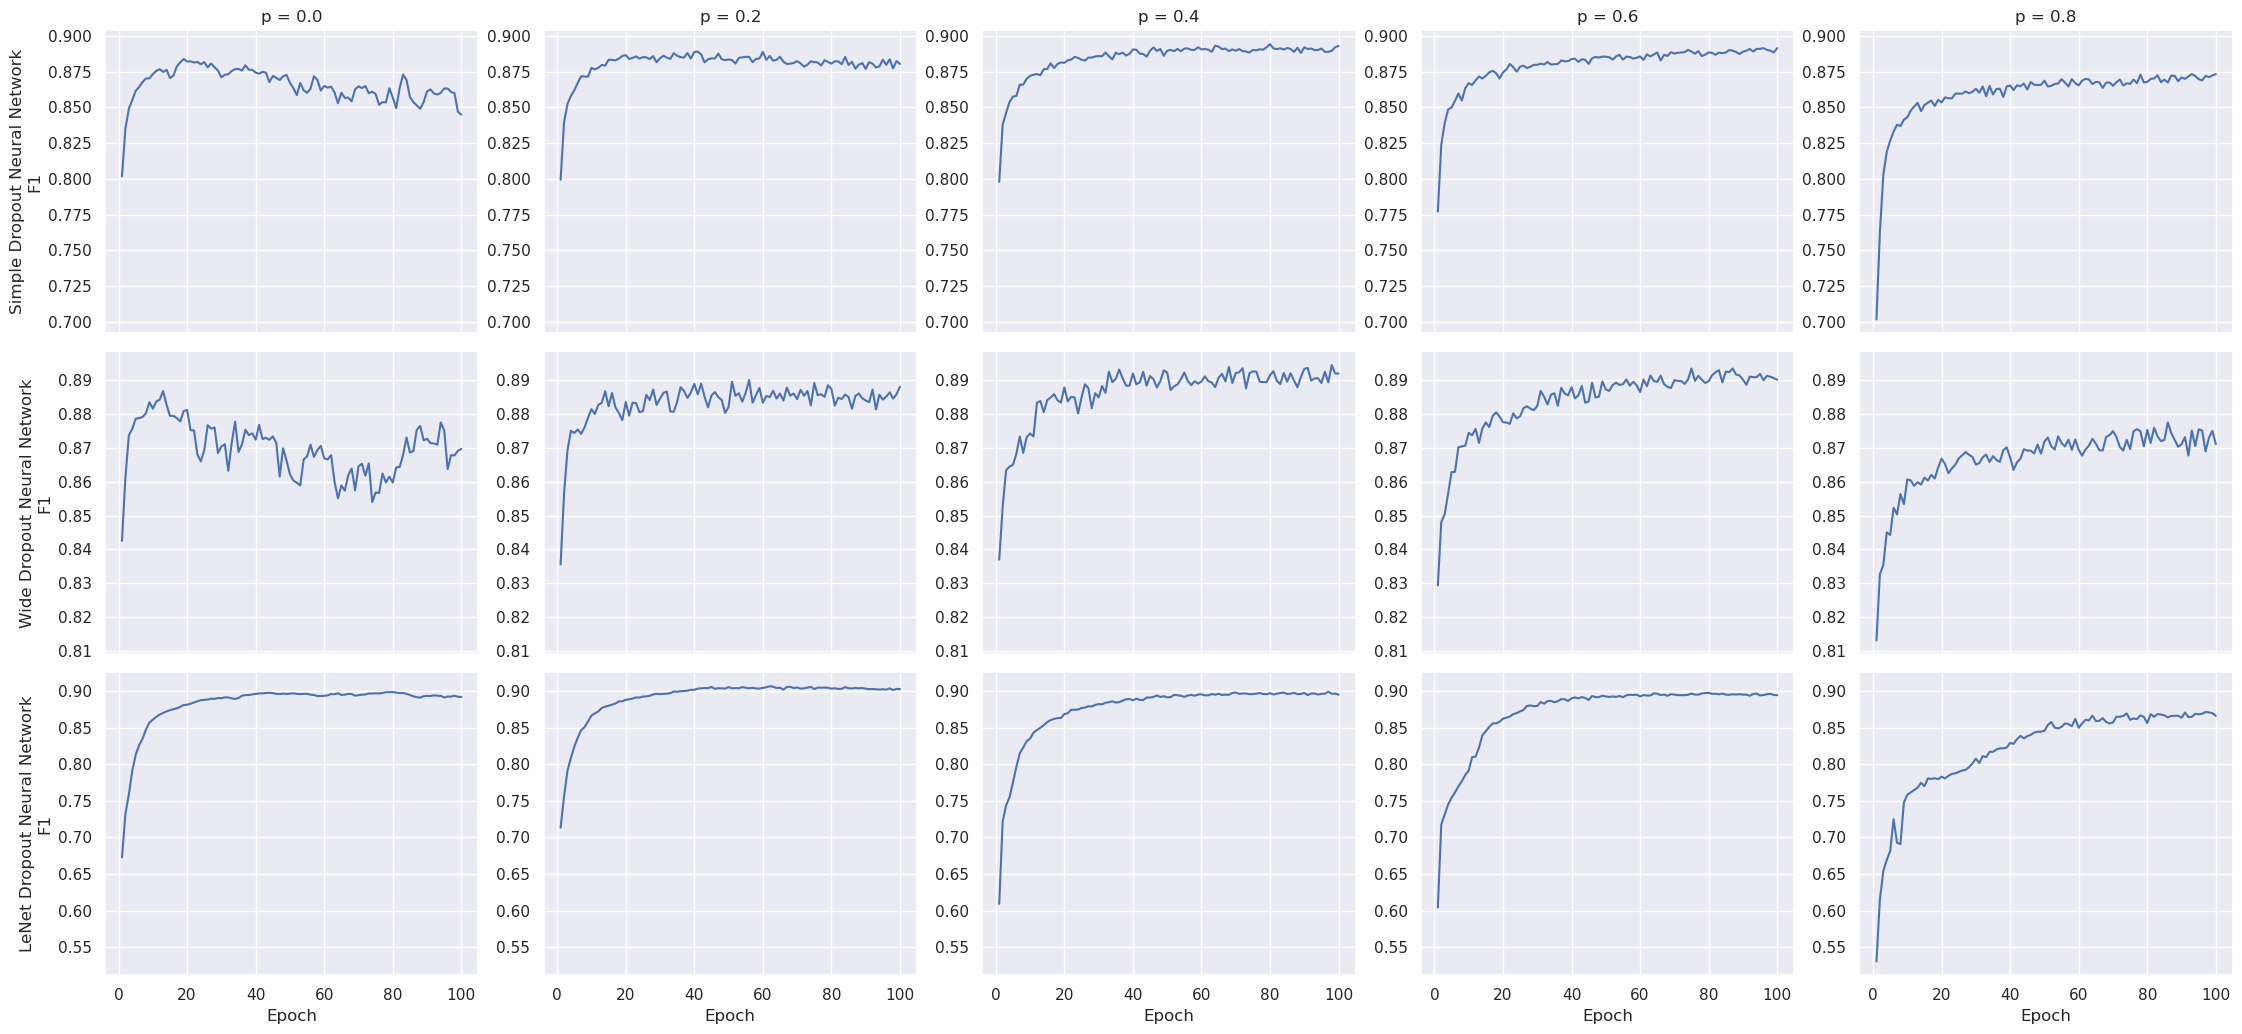

In [69]:
plot_dropout_histories(results, metric="f1")

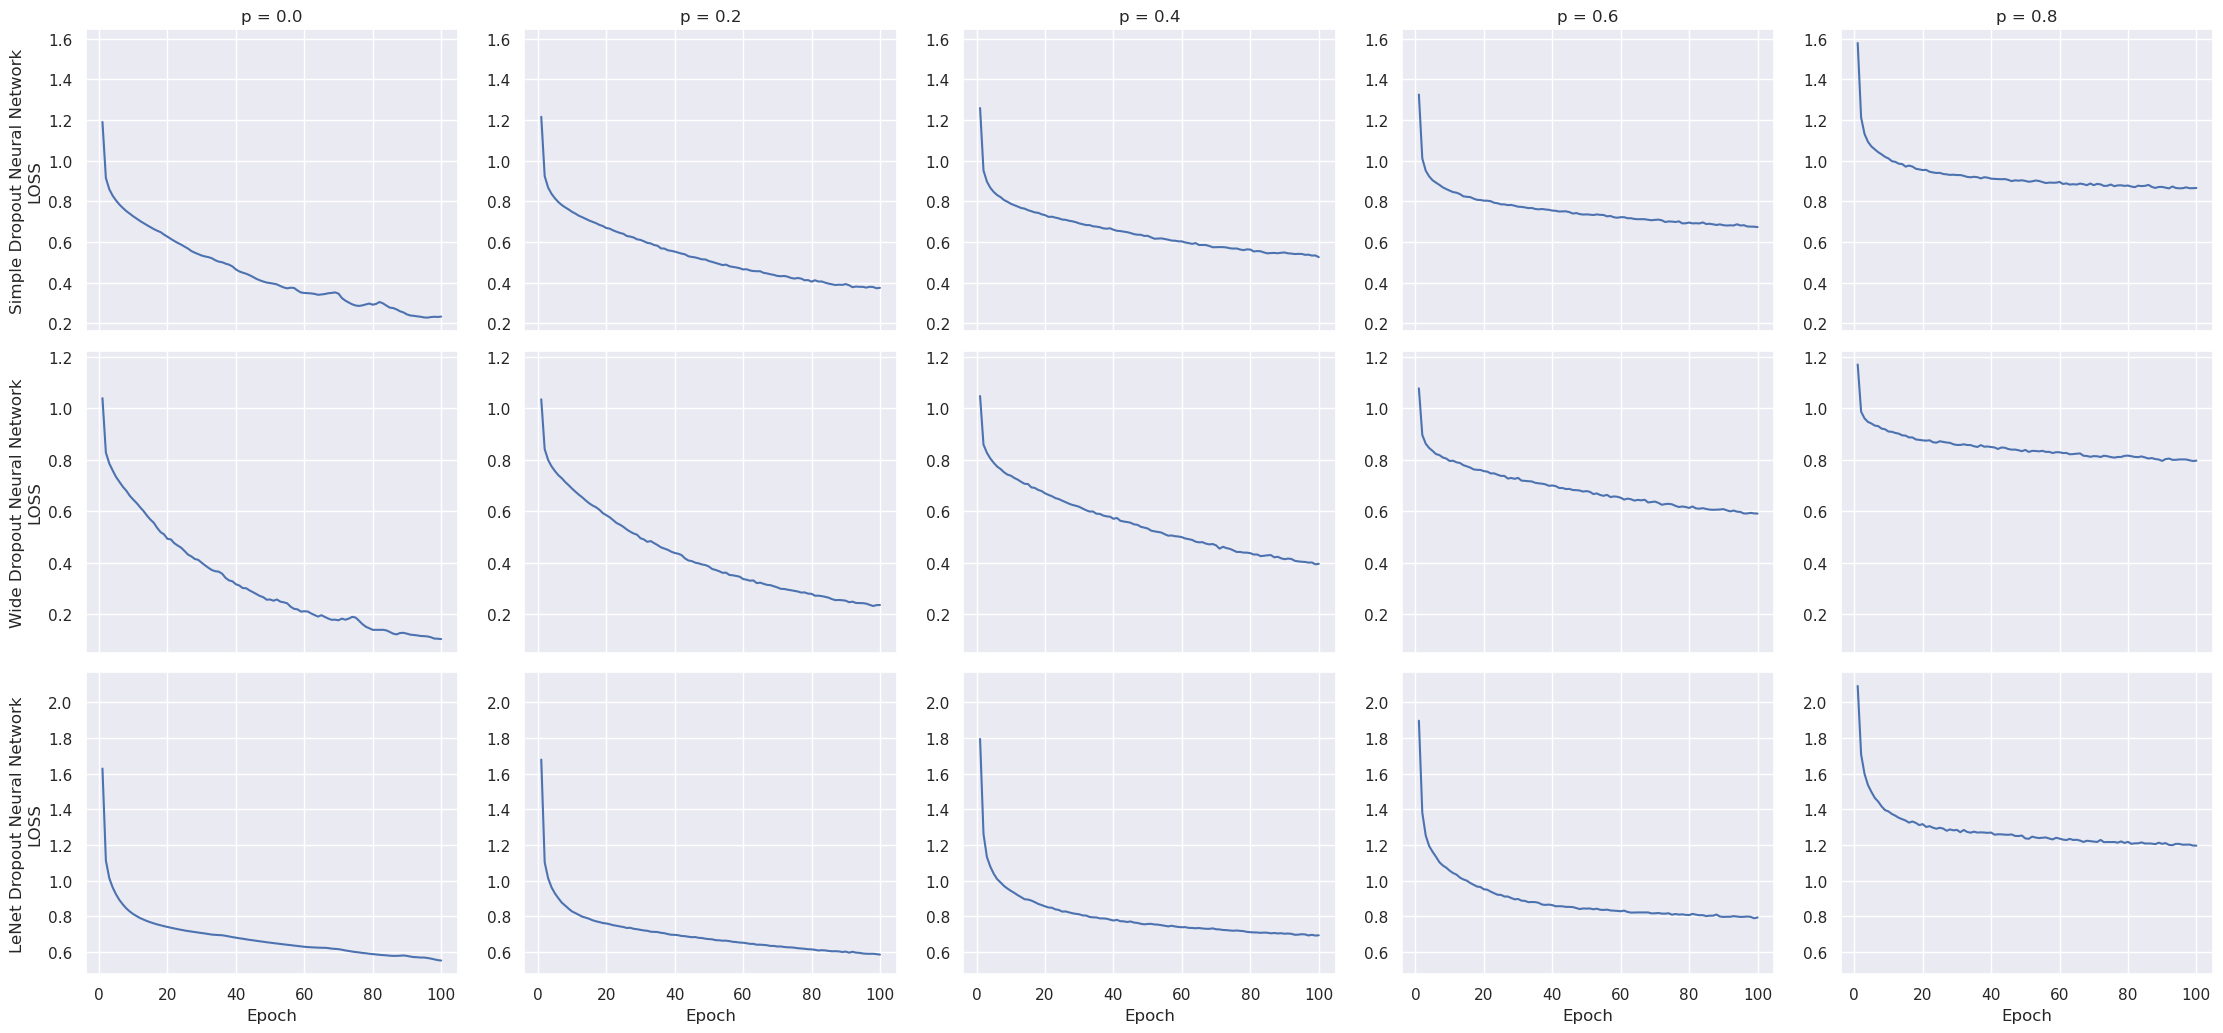

In [70]:
plot_dropout_histories(results, metric="loss")

In [ ]:
# CIFAR-10